In [1]:
%matplotlib inline
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
import pymysql as sql
import itertools
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import itertools

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import linear_model

#creating the connection to the postgres
engine = create_engine('postgres://%s@localhost/%s'%('hesamparsa','ddvklh47a15s65'))  
print(engine.url)

postgres://hesamparsa@localhost/ddvklh47a15s65


/Users/hesamparsa/anaconda/envs/my_projects_env/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
# reading Conekta csv file and saving it as conekta_data. This table has the labels for the transactions: (paid or charged-back)
conekta = pd.DataFrame.from_csv('conekta.csv')
conekta.to_sql('conekta_data', engine, if_exists='replace')

In [2]:
# Quering the first part of the modeling data for each transaction over years 2016
# note that every user can have multiple transactions
# X: amount, days_on_moneypool, no_of_conections, estatus y: estatus
con = psycopg2.connect(database = 'ddvklh47a15s65' , user = 'hesamparsa')
sql_query = '''
SELECT     
    payments.user_id AS user_id,
    conekta_data.id_cargo AS "Conekta_Transaction_ID",
    conekta_data.monto_cargo AS amount,
    (EXTRACT (epoch FROM age(users.created_at))/(60*60*24)) AS days_on_moneypool,
    COUNT (friendships.user_id) AS no_of_conections,
    conekta_data.estatus  
FROM
    payments
    INNER JOIN conekta_data ON payments.conekta_id = conekta_data.id_cargo
    INNER JOIN users ON payments.user_id = users.id
    LEFT JOIN friendships ON payments.user_id = friendships.user_id
WHERE
    payments.created_at BETWEEN '2016-01-01T06:00:00+00:00' AND '2017-01-01T05:59:59+00:00' 
GROUP BY
    conekta_data.monto_cargo,
    conekta_data.estatus, 
    conekta_data.id_cargo, 
    payments.conekta_id, 
    users.created_at,
    payments.user_id,
    users.id
;'''

first=pd.read_sql_query(sql_query,con)
first.head()

,user_id,Conekta_Transaction_ID,amount,days_on_moneypool,no_of_conections,estatus
0,22568,569a742c19ce886a4b002e0b,3.0,429.397969,90,paid
1,24651,56abba4419ce88332e000306,3.0,401.498492,213,paid
2,27157,56b596eb19ce8831bc002f4d,3.0,373.977110,49,paid
3,31762,56d07729241229706a0020ea,3.0,347.335360,3,paid
4,47151,56df612919ce88e27a004579,3.0,336.033776,2,paid


In [3]:
# Changing the status label to numeric values:
first['result']=first.estatus.map({'paid':0,'charged_back':1, 'refunded':2, 'partially_refunded':3, 
                                   'pending_payment':4})
#we only care about: paid,charged_back:
first = first[(first.result == 0) | (first.result == 1)]

# Here we have 64236 transactions from 25843 unique users.
# we calculate the sum of all amounts paid by users over multiple transactions
# and if a user transaction once labeled as charged back we consider that. 
first1=first.groupby(['user_id']).agg({'amount': 'sum', 'days_on_moneypool':'max', 'no_of_conections':'max',
                                       'result': 'max'}).reset_index()
first1.head()

,user_id,result,amount,days_on_moneypool,no_of_conections
0,5,0,25.75,1180.042712,25
1,12,0,4256.51,1178.485204,501
2,15,0,10955.85,1177.784936,524
3,16,0,617.40,1177.784737,25
4,17,0,9136.92,1176.756805,251


In [4]:
# We have 25302 regular users and 541 fraudsters
first1.result.value_counts()

0    25302
1      541
Name: result, dtype: int64

In [5]:
#Quering the second part of the modeling data: How many times the user tried to use a credit card censecutively (make a payment)
con = psycopg2.connect(database = 'ddvklh47a15s65' , user = 'hesamparsa')

sql_query = '''
SELECT  user_id, receiver_id, amount, cast(created_at as date), COUNT(*) AS total_attempt
FROM payments
WHERE payments.created_at BETWEEN '2016-01-01T06:00:00+00:00' AND '2017-01-01T05:59:59+00:00' 
GROUP BY user_id, receiver_id, amount, cast(created_at as date)
;'''

sec=pd.read_sql_query(sql_query,con)
sec.head()

,user_id,receiver_id,amount,created_at,total_attempt
0,5,14989,25.0,2016-07-01,1
1,12,374,300.0,2016-12-06,1
2,12,467,290.0,2016-12-16,1
3,12,522,212.0,2016-12-22,1
4,12,7665,50.0,2016-01-20,1


In [6]:
# Find the maximum of total_attempt
sec1 = sec['total_attempt'].groupby(sec['user_id']).max().reset_index()
sec1.head()

,user_id,total_attempt
0,5,1
1,12,1
2,15,4
3,16,1
4,17,1


In [7]:
#Quering the third part of the modeling data: 
#This is the time interval between when a user created an account and when s/he updated his/her credit card information
con = psycopg2.connect(database = 'ddvklh47a15s65' , user = 'hesamparsa')
sql_query = '''
SELECT     
    cards.user_id,
    extract(day FROM cards.updated_at-users.created_at) AS card_updated_time_diff

FROM
    cards
    INNER JOIN users ON cards.user_id = users.id
    INNER JOIN payments ON payments.user_id=cards.user_id
    
WHERE
    payments.created_at BETWEEN '2016-01-01T06:00:00+00:00' AND '2017-01-01T05:59:59+00:00' 
GROUP BY
    cards.user_id,
    cards.updated_at,
    users.id
;'''

third=pd.read_sql_query(sql_query,con)
third.head()

,user_id,card_updated_time_diff
0,277174,0.0
1,269669,0.0
2,253035,36.0
3,267563,0.0
4,25499,264.0


In [8]:
# This line finds the maximum of card_updated_time_diff for each user
third1 = third['card_updated_time_diff'].groupby(third['user_id']).max().reset_index()
third1.shape

(26031, 2)

In [9]:
con = psycopg2.connect(database = 'ddvklh47a15s65' , user = 'hesamparsa')
sql_query = '''
SELECT     
    liabilities.user_id, 
    liabilities.pool_id
FROM
    liabilities
    INNER JOIN payments ON payments.user_id=liabilities.user_id
WHERE
    (payments.created_at BETWEEN '2016-01-01T06:00:00+00:00' AND '2017-01-01T05:59:59+00:00') AND 
    admin = 'True'
GROUP BY
    liabilities.user_id, 
    liabilities.pool_id
;'''
fourth=pd.read_sql_query(sql_query,con)
fourth.head()

,user_id,pool_id
0,12797,8016
1,199355,14000
2,480,26662
3,2214,22759
4,20521,6013


In [10]:
#fourth=fourth.drop_duplicates()
fourth1=fourth.groupby('user_id').count().reset_index()
fourth2=fourth1.rename(columns={'pool_id': 'no_pool_admin'})
fourth2.shape

(6290, 2)

In [11]:
#Quering the fifth part of the modeling data: 
#This is the time interval between when a payment is made and when s/he withdraw money to his/her bank account

con = psycopg2.connect(database = 'ddvklh47a15s65' , user = 'hesamparsa')
sql_query = '''
SELECT     
    payments.user_id,
    extract(days FROM bank_withdrawals.updated_at-payments.created_at) AS withdraw_payment_date_diff
FROM
    payments
    INNER JOIN bank_withdrawals ON bank_withdrawals.user_id = payments.user_id 
    INNER JOIN users ON users.id = payments.user_id 
        
WHERE
    (payments.created_at BETWEEN '2016-01-01T06:00:00+00:00' AND '2017-01-01T05:59:59+00:00') 
    
GROUP BY
    bank_withdrawals.user_id,
    bank_withdrawals.updated_at,
    payments.user_id,
    payments.created_at
;'''

fifth=pd.read_sql_query(sql_query,con)


In [12]:
# Here we count the number of times that withdraw_payment_date_diff is within 3 hrs
fifth['withdraw_payment_date_diff_t'] = fifth['withdraw_payment_date_diff'].apply(lambda x: 0 if ((x <= 0) | (x>=3)) else 1)
fifth1 = fifth['withdraw_payment_date_diff_t'].groupby(fifth['user_id']).count().reset_index()  #this was max orginaly and 3 hr
#fifth1.withdraw_payment_date_diff_t.value_counts()
#fifth1.sample(100)

In [13]:
#Here we calculate pool age in days
con = psycopg2.connect(database = 'ddvklh47a15s65' , user = 'hesamparsa')
sql_query = '''
Select
    pool_id,
    (EXTRACT (epoch FROM age(pools.created_at))/(60*60*24)) AS "pool_age"
FROM
    liabilities
    INNER JOIN pools on pools.id = liabilities.pool_id
;'''

pools_age=pd.read_sql_query(sql_query,con)
pools_age.head()

,pool_id,pool_age
0,8789,351.229496
1,5032,458.489020
2,8113,377.245292
3,11659,300.163550
4,13891,248.353066


In [14]:
pools_age.shape

(137295, 2)

In [15]:
# Here we calculate the age of the users in all of the pools
con = psycopg2.connect(database = 'ddvklh47a15s65' , user = 'hesamparsa')
sql_query = '''
Select
    pool_id,
    user_id,
    (EXTRACT (epoch FROM age(users.created_at))/(60*60*24)) AS "user_age"
FROM
    liabilities
    INNER JOIN users on users.id = liabilities.user_id
;'''

pools_user_age=pd.read_sql_query(sql_query,con)
pools_user_age.head()

,pool_id,user_id,user_age
0,8789,1575,864.781687
1,5032,22718,428.491449
2,8113,23606,423.243784
3,13891,19721,445.285562
4,13560,198143,247.092877


In [16]:
pools_user_age.shape

(137295, 3)

In [17]:
#Here we calculate the median of user age for each pool
pools_user_age1=pools_user_age.groupby('pool_id')['user_age'].median().reset_index()
pools_user_age1 = pools_user_age1.rename(columns={'user_age': 'median_users_age'})
pools_user_age1.shape

(27781, 2)

In [18]:
pool = pd.merge(pools_age,pools_user_age1, how='left', on=['pool_id']).fillna(0)
pool.sample(10)

,pool_id,pool_age,median_users_age
112747,7750,388.546993,689.591539
54364,22164,109.240371,103.339460
55016,11182,309.166694,309.131077
27603,21859,113.227931,261.232104
126770,22684,102.184827,438.269045
58918,19458,151.962407,637.124455
87223,1511,596.325628,596.015457
590,5032,458.489020,428.435154
134583,26955,54.220175,432.543719
113274,7899,383.550933,485.352055


In [19]:
pool.shape

(137295, 3)

In [20]:
# Here using a liability table, we find which user belongs to which pool
con = psycopg2.connect(database = 'ddvklh47a15s65' , user = 'hesamparsa')
sql_query = '''
Select
    user_id,
    pool_id
FROM
    liabilities
GROUP BY
    liabilities.user_id,
    pool_id
;'''

liabil=pd.read_sql_query(sql_query,con)
liabil.head()

,user_id,pool_id
0,28494,8892
1,171284,13169
2,28531,23694
3,37,6497
4,3006,21892


In [21]:
pool.shape

(137295, 3)

In [22]:
liabil_full = pd.merge(liabil,pool, how='left', on=['pool_id']).fillna(0)
liabil_full.head()

,user_id,pool_id,pool_age,median_users_age
0,28494,8892,349.991557,349.998232
1,171284,13169,267.158057,300.600851
2,171284,13169,267.158057,300.600851
3,28531,23694,89.137490,341.134937
4,28531,23694,89.137490,341.134937


In [23]:
liabil_full.shape

(5224051, 4)

In [24]:
#Here we find the median of median of pool age, median of median_users_age, and total number of pool that the user subscribed to 
liabil_full1=liabil_full.groupby(['user_id']).agg({'pool_age': 'median', 'median_users_age':'median',
                                                   'pool_id': 'count'}).reset_index()
liabil_full2 = liabil_full1.rename(columns={'pool_age':'median_pool_age', 'median_users_age':'median_median_users_age',
                                            'pool_id':'no_of_pool'})
liabil_full2.head()

,user_id,median_pool_age,median_median_users_age,no_of_pool
0,1,608.513609,1166.570804,33
1,2,996.601809,995.178841,721
2,3,1124.764204,1165.762237,12
3,5,224.224245,223.847805,128
4,6,1180.045391,1180.042712,3


In [25]:
con = psycopg2.connect(database = 'ddvklh47a15s65' , user = 'hesamparsa')
sql_query = '''
Select
    users.id, gender
FROM
    users
;'''

age=pd.read_sql_query(sql_query,con)
age.head()

,id,gender
0,77926,None
1,285265,female
2,77929,None
3,285273,male
4,285282,male


In [26]:
age['gender1']=age.gender.map({'female':0,'male':1,'None':2})
age=age.fillna(2)
age1=age.drop('gender', 1)
age2 = age1.rename(columns={'id':'user_id', 'gender1':'gender'})
age2.gender.value_counts()

2.0    28647
1.0    24491
0.0    16363
Name: gender, dtype: int64

In [27]:
#mereged all the data that we preprocessed
mpdata1 = pd.merge(first1,sec1, how='inner', on=['user_id'])
mpdata2 = pd.merge(mpdata1,third1, how='left', on=['user_id'])
mpdata3 = pd.merge(mpdata2,fourth2, how='left', on=['user_id']).fillna(0)
mpdata4 = pd.merge(mpdata3,fifth1, how='left', on=['user_id']).fillna(0)
mpdata5 = pd.merge(mpdata4,liabil_full2, how='left', on=['user_id']).fillna(0)
mpdata = pd.merge(mpdata5,age2, how='left', on=['user_id']).fillna(0)
mpdata['adminity']=mpdata['no_pool_admin']/mpdata['no_of_pool']
mpdata = mpdata.fillna(0)
mpdata.isnull().values.any()

False

In [28]:
variable_string=np.array(['user_id',
                 'gender',
                 'no_pool_admin','no_of_pool','adminity','median_pool_age','median_median_users_age',
                 'days_on_moneypool','no_of_conections',
                 'withdraw_payment_date_diff_t','card_updated_time_diff','amount', 'total_attempt', 
                 'result'])
variable_dict = {'user_id':'User ID',
                'gender':'Gender',
                'no_pool_admin':'No. of Pools Served as Admin', 
                'no_of_pool':'No. of Pools',
                'adminity':'Frequency of Being Admin',
                'median_pool_age':'Median of Pool age (days)',
                'median_median_users_age':'Median of friends Age(days)',
                'days_on_moneypool':'User Age on Moneypool',
                'no_of_conections':'No. of Connections',
                'withdraw_payment_date_diff_t':'Pay/withdrawal Interval(days)',
                'card_updated_time_diff':'Card Update Delay(days)',
                'amount':'Total Payment Amount(Mex$)',
                'total_attempt':'No. of Attempts to Use a Card',
                'result':'Label'}

In [29]:
td = mpdata[variable_string]
#data_range = np.arange(2,13)  # Here we choose the range of the data that we want from td
data_range=np.array([2,3,4,5,6,7,8,9,10,11,12])
variable_dict_name = [variable_dict[x] for x in variable_string[data_range]]
X=td.iloc[:,data_range]
y=td.iloc[:,len(variable_string)-1:len(variable_string)]
# split X and y into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
#print(X_train.shape)
print(td.shape)

(25843, 14)


In [30]:
variable_dict_name

['No. of Pools Served as Admin',
 'No. of Pools',
 'Frequency of Being Admin',
 'Median of Pool age (days)',
 'Median of friends Age(days)',
 'User Age on Moneypool',
 'No. of Connections',
 'Pay/withdrawal Interval(days)',
 'Card Update Delay(days)',
 'Total Payment Amount(Mex$)',
 'No. of Attempts to Use a Card']

(0, 1000)

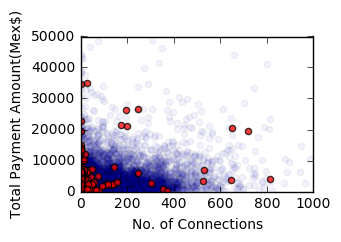

In [31]:
import matplotlib.cm as cm
i=8
j=11
plt.figure(figsize=(3,2))
colors = ['blue','red']
cl0=td[td.iloc[:,13]==0].iloc[:,[i,j]]
cl1=td[td.iloc[:,13]==1].iloc[:,[i,j]]
plt.scatter(cl0.iloc[:, 0],cl0.iloc[:, 1], c=colors[0], alpha = 0.05)
plt.scatter(cl1.iloc[:, 0],cl1.iloc[:, 1], c=colors[1], alpha = 0.75)
plt.xlabel(variable_dict_name[i-2])
plt.ylabel(variable_dict_name[j-2])
plt.ylim([0, 50000])
plt.xlim([0, 1000])

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import binarize
rfclf = RandomForestClassifier(class_weight="balanced", n_estimators=400)
rfclf = rfclf.fit(X_train, y_train)
y_pred_proba = rfclf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
y_pred_class=binarize(y_pred_proba,0.015)[0]
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_class)

/Users/hesamparsa/anaconda/envs/my_projects_env/lib/python3.5/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/hesamparsa/anaconda/envs/my_projects_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


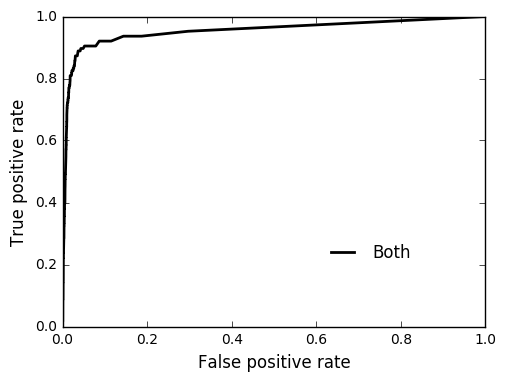

In [33]:
fig = plt.figure(figsize=(12,4)) 
ax1 = fig.add_subplot(121)
ax1.plot(fpr,tpr,'black',linewidth=2)
ax1.set_xlabel("False positive rate", fontsize=12)
ax1.set_ylabel("True positive rate", fontsize=12)
legname = 'Both'
leg = ax1.legend((legname,), loc=4, bbox_to_anchor=(0.86, 0.16))
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_facecolor('none')
#filename = '/Users/hesamparsa/Desktop/coef/logreg/' + legname + '.png'
#fig.savefig(filename, transparent=True)

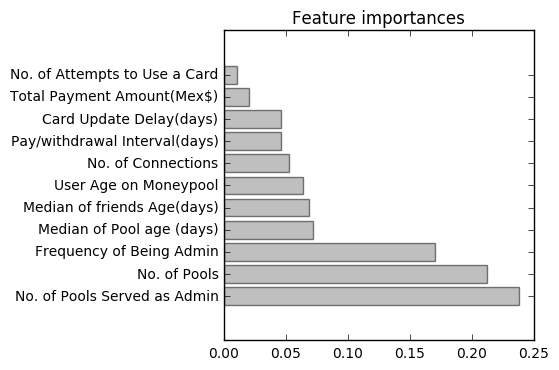

In [34]:
# Plot the feature importances of the forest
importances = rfclf.feature_importances_
indices = np.argsort(importances)[::-1]
fig = plt.figure(figsize=(4,4)) 
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],color="grey", align="center", alpha=0.5)
plt.yticks(range(X.shape[1]), variable_dict_name[0:X.shape[1]+1])  
#plt.ylim([-1, X.shape[1]])
#plt.xlim([0, 0.25])
plt.show()

In [ ]:
logreg = LogisticRegression(class_weight="balanced")
logreg.fit(X_train, y_train)
y_pred_proba = logreg.predict_proba(X_test)[:,1]
fprlr, tprlr, thresholdslrg = metrics.roc_curve(y_test, y_pred_proba)
y_pred_class=binarize(y_pred_proba,0.5)[0]
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_class)

In [ ]:
# Plot the correlation coeff of log reg
logreg_importances=logreg.coef_[0]
logreg_importancesn = -logreg.coef_[0]
indices = np.argsort(logreg_importances)[::-1]
plt.figure()
plt.title("Correlation Coefficient")
plt.barh(range(X.shape[1]), logreg_importancesn[indices], color="grey", align="center", alpha=0.5)
plt.yticks(range(X.shape[1]), variable_dict_name[0:X.shape[1]+1]) 
#plt.ylim([-1, X.shape[1]])
plt.xlim([-5, 0.2])
plt.show()

In [37]:
# cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import binarize
logregcv = LogisticRegression(class_weight="balanced")
ylist=y.result.tolist()
# cross-validation scores
y_pred_probacv = cross_val_predict(logregcv, X, ylist, cv=10, method='predict_proba')[:,1]
fprlrcv, tprlrcv, thresholdslrcv = metrics.roc_curve(ylist, y_pred_probacv)
y_pred_classcv=binarize(y_pred_probacv,0.5)[0]
cnf_matrix = metrics.confusion_matrix(ylist, y_pred_classcv)

/Users/hesamparsa/anaconda/envs/my_projects_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Confusion matrix, without normalization
[[ 0.92  0.08]
 [ 0.09  0.91]]


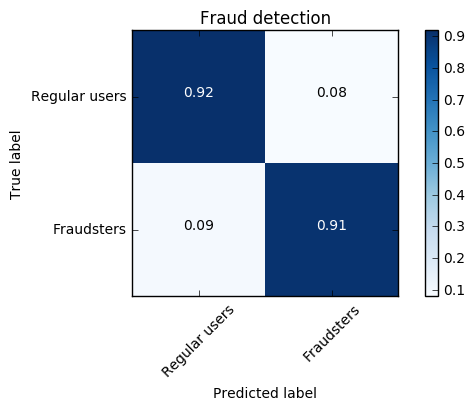

In [57]:
total_ok=cnf_matrix[0][0]+cnf_matrix[0][1]
total_fraud=cnf_matrix[1][1]+cnf_matrix[1][0]
cnfmn=cnf_matrix.astype('float')
cnfmn[0][0]=cnf_matrix[0][0]/total_ok
cnfmn[0][1]=cnf_matrix[0][1]/total_ok
cnfmn[1][0]=cnf_matrix[1][0]/total_fraud
cnfmn[1][1]=cnf_matrix[1][1]/total_fraud
cnfmn
cnfmn[0][0] = float("{0:.2f}".format(cnfmn[0][0]))
cnfmn[0][1] = float("{0:.2f}".format(cnfmn[0][1]))
cnfmn[1][0] = float("{0:.2f}".format(cnfmn[1][0]))
cnfmn[1][1] = float("{0:.2f}".format(cnfmn[1][1]))
class_names = ['Regular users', 'Fraudsters']
plot_confusion_matrix(cnfmn, classes=class_names, title='Fraud detection')

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
        

In [40]:
df=td
probdf=pd.DataFrame(y_pred_proba,columns=['prob'])
classdf=pd.DataFrame(y_pred_class,columns=['pred class'])
df['prob']=probdf['prob']
df['pred class']=classdf['pred class']
df.sort_values(['prob'], ascending=False, inplace=True)
df.to_csv('alldata.csv')

/Users/hesamparsa/anaconda/envs/my_projects_env/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/hesamparsa/anaconda/envs/my_projects_env/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/hesamparsa/anaconda/envs/my_projects_env/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/

In [54]:
risky = df.loc[(df['pred class']==1)]
risky.to_csv('risky.csv')

In [55]:
risky.shape

(611, 16)

In [42]:
con = psycopg2.connect(database = 'ddvklh47a15s65' , user = 'hesamparsa')
sql_query = '''
Select
    user_id,
    pool_id
FROM
    liabilities
;'''

p=pd.read_sql_query(sql_query,con)
p.to_csv('pooldata.csv')

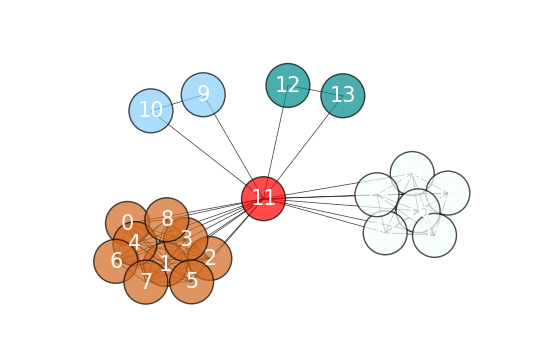

In [43]:
import random
from matplotlib.colors import cnames
userid=90968
sp=p.loc[(p['user_id'] == userid)].pool_id.tolist()
counter=0
index_user=0
su=[]
G=[]
G=nx.Graph()
ncolor=[]
lsu=[]
nlist=[]
#mlist=[]
for i in range(0, len(sp)):
    su=p.loc[(p['pool_id'] == sp[i])].user_id.tolist()    
    lsu.append(su)
ulsu=np.unique(lsu)
for i in range(0, len(ulsu)):
    color_index = random.randrange(0,150)
    for j in range(0, len(ulsu[i])):
        G.add_node(counter, user_id = ulsu[i][j])
        ncolor.append(list(cnames.keys())[color_index])
        nlist.append(counter)
        counter+=1
    if ([userid] == ulsu[i]):
        index_user = (counter-1)
    G.add_edges_from(list(itertools.combinations(nlist, 2)))
    #mlist.append(nlist)
    nlist=[]
ncolor[index_user]='Red'
G.add_edges_from(list(itertools.product([index_user], np.arange(counter))))
pos = nx.spring_layout(G)
ax=nx.draw_networkx_edges(G, pos, width = 0.5, alpha=0.8);
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color = ncolor, alpha=0.7);
nx.draw_networkx_labels(G, pos, font_size = 15,font_color ='white', font_family = 'sans-serif');
plt.axis('off');